# Introducció a la pràctica 2



# Apartat (A): Comparativa de models (4pts)

L'objectiu d'aquest apartat és aprendre a comparar el rendiment obtingut amb els diferents models, utilitzant les mètriques adequades: precision-recall, accuracy, corba ROC, F1 score, etc... 

Es tracta d'ordenar per rendiment i descriure el per què dels resultats obtinguts amb els mètodes utilitzats en el següent apartat B.

A continuació us posem el codi bàsic per a una base de dades concreta, en el vostra cas haureu d'utilitzar la que se us ha assignat (veure la taula de dalt).

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')
    
# import some data to play with
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset('data/train.csv')

# Take the first two features. We could avoid this by using a two-dim dataset
data = dataset.values


In [15]:
X = data[:, [0, 13]]
y = data[:, 20]

X.shape

(2000, 2)

In [16]:
dataset.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Correct classification Logistic  0.5 % of the data:  0.83
Correct classification SVM       0.5 % of the data:  0.239
Correct classification Logistic  0.7 % of the data:  0.825
Correct classification SVM       0.7 % of the data:  0.21833333333333332
Correct classification Logistic  0.8 % of the data:  0.8525
Correct classification SVM       0.8 % of the data:  0.22


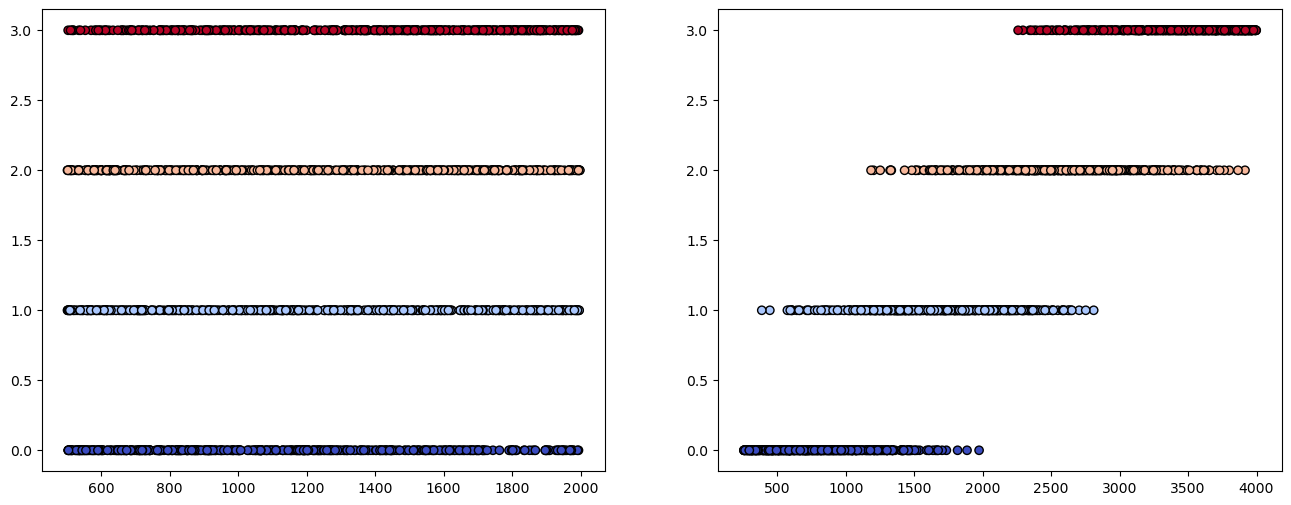

In [17]:
fig, sub = plt.subplots(1, 2, figsize=(16,6))
#Battery power
sub[0].scatter(X[:,0], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
#RAM
sub[1].scatter(X[:,1], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')


particions = [0.5, 0.7, 0.8]

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

    # l'entrenem
    logireg.fit(x_t, y_t)

    print ("Correct classification Logistic ", part, "% of the data: ", logireg.score(x_v, y_v))
    
    #Creem el regresor logístic
    svc = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True)

    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Correct classification SVM      ", part, "% of the data: ", svc.score(x_v, y_v))

Tal com podeu llegir a [l'API de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html), en comptes de fer una corba per cada classe, podem considerar totes les classes en conjunt en una sola corba (1 si hem predit la classe correcta, 0 si no). Això es coneix com a `micro-averaging`. 

Així, veureu que la funció `f1_score` utilitza el paràmetre `macro` per calcular la precision-recall-f1 per clase, i després fer la mitja pr a totes les classes; i `micro` per utilitzar totes les prediccions (i errors de FN, FP) per a calcular una única precision-recall-f1 per a totes les classes juntes.

Si voleu calcular la corba Precision-Recall quan utilitzeu el K-fold, cal calcular les corbes per a cada fold i després [fer la mitja de tots els folds per obtenir la corba final](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py). En el cas del LOOCV no té sentit fer la mitja la corba PR perquè hauriem de fer servir totes les mostres com a $y$.


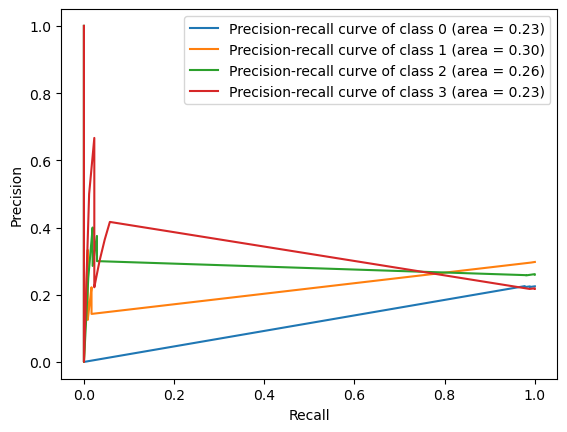

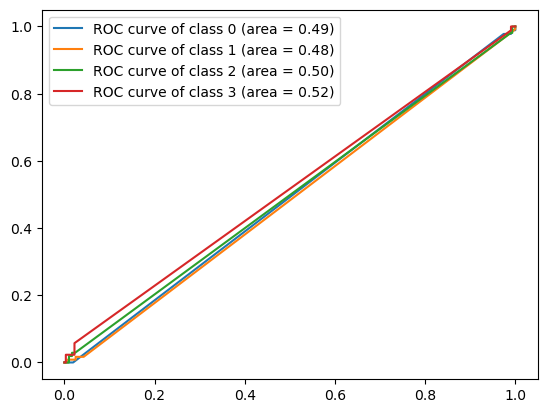

In [18]:
n_classes = 4
# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
    average_precision[i] = average_precision_score(y_v == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def show_C_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    dataset = load_dataset('data/train.csv')
    # Take the first two features. We could avoid this by using a two-dim dataset
    data = dataset.values

    X = data[:, [0, 13]]
    y = data[:, 20]
    X = Normalizer().fit(X).transform(X)
    
    
    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    titles = ('SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel')

    #C = 1.0  # SVM regularization parameter
    models = (svm.SVC(kernel='linear', C=C),
              svm.LinearSVC(C=C, max_iter=1000000),
              svm.SVC(kernel='rbf', gamma=gamma, C=C),
              svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C))
    models = (clf.fit(X, y) for clf in models)
    
    plt.close('all')
    fig, sub = plt.subplots(2, 2, figsize=(14,9))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

    


Podeu provar quin efecte té diferents valors de regularització per aquest petit exemple ( C=0.0001 to 1000..). També podeu veure com afecta els valors de degree i gamma. 

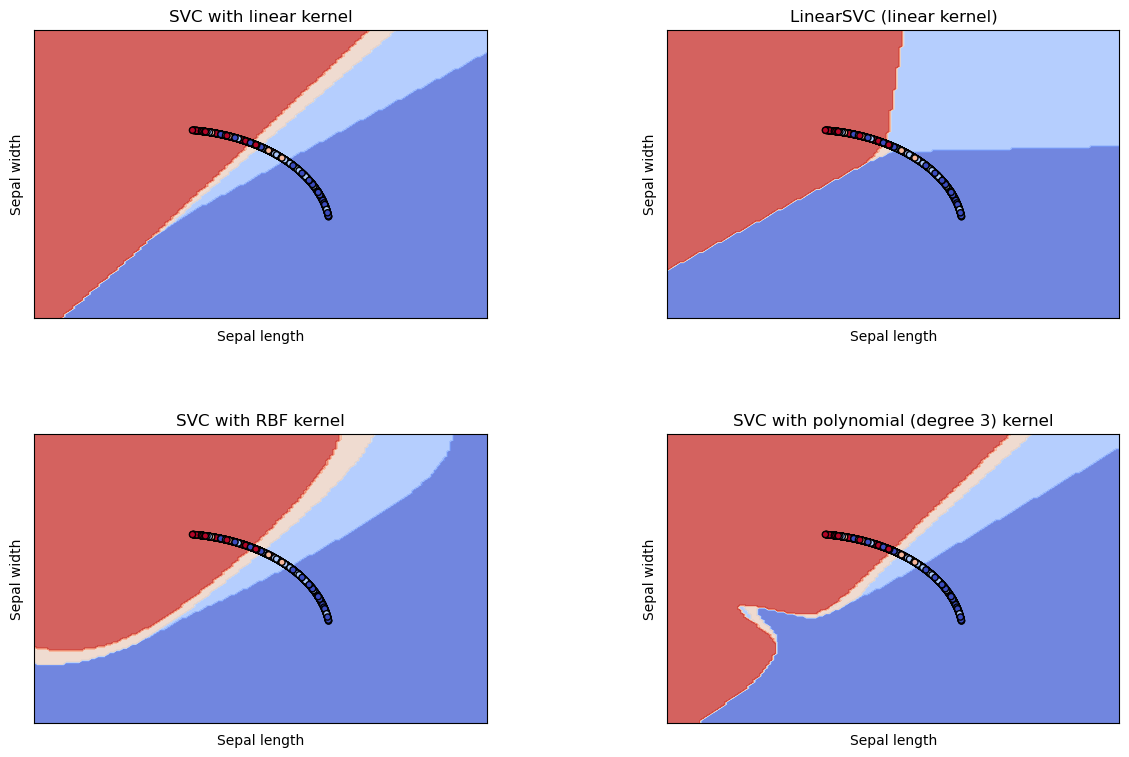

In [21]:
show_C_effect(0.1)

# Apartat (B): Classificació Numèrica (6pts)

Per a aquest primer apartat, s'analitzarà els tipus d'atributs que es tenen i, si no està estipulat, **caldrà fixar quin és l'atribut objectiu a classificar de tots els que hi ha a la base de dades**.
Expliqueu a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.

Treballarem varis aspectes de la classificació:

1. EDA (exploratory data analysis)
2. Preprocessing (normalitzation, outlier removal, feature selection..)
3. Model Selection
4. Crossvalidation
5. Metric Analysis
6. Hyperparameter Search


Durant els següents apartats, es recomana anar fent una taula amb el mètode, paràmetres i precisió obtinguda. D'aquesta manera serà més fàcil entendre i valorar què s'aconsegueix en cada metode. Exemple:

<img src="images/table_1.png" width="80%">

Les preguntes de cada apartat són orientatives. **NO** cal contestar-les totes, ni totes tindrán sentit per tots els datasets. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat. Tot i no ser obligatories, si que són molt recomenades d'intentar respondre.

### 1. EDA (exploratory data analysis)

Igual com a la pràctica anterior, exploreu i visualitzeu com és la base de dades que teniu assignada.

**Preguntes:**
* Quants atributs té la vostra base de dades?
* Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)
* Com es el target, quantes categories diferents existeixen?
* Podeu veure alguna correlació entre X i y?
* Estan balancejades les etiquetes (distribució similar entre categories)? Creus que pot afectar a la classificació la seva distribució?


In [62]:
dataset.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [63]:
dataset.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Text(0.5, 1.0, 'Correlation')

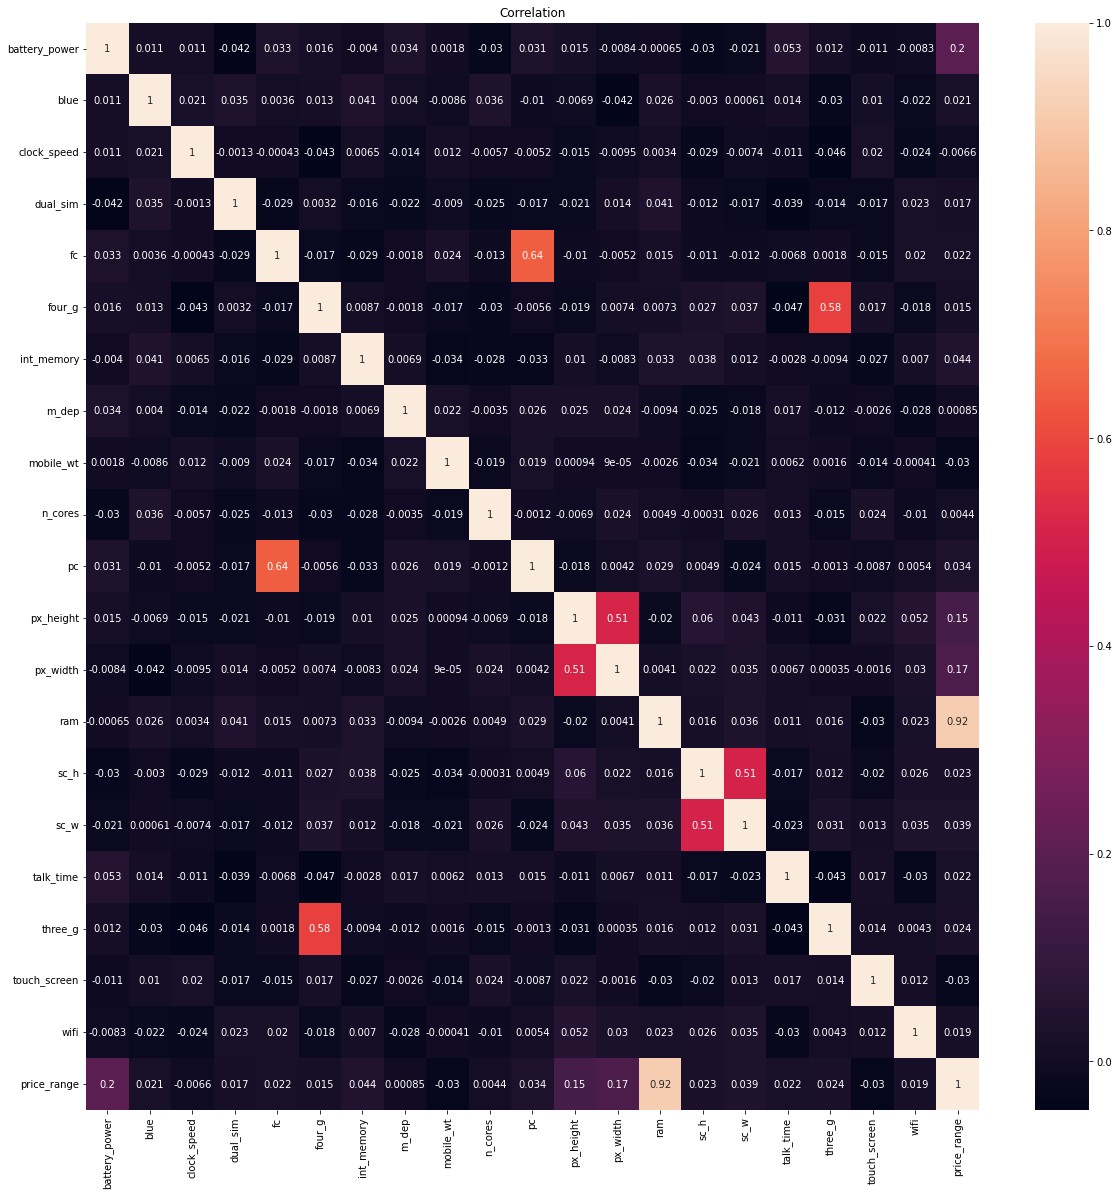

In [29]:
corr=dataset.corr()
fig = plt.figure(figsize=(20,20))
r = sns.heatmap(corr, annot=True)
r.set_title("Correlation")

In [34]:
#X = dataset.drop('price_range',axis=1)
#y = dataset['price_range']
X = data[:, [0,11,12,13]]
y = data[:, 20]

In [35]:
dataset['price_range'].unique()

array([1, 2, 3, 0])

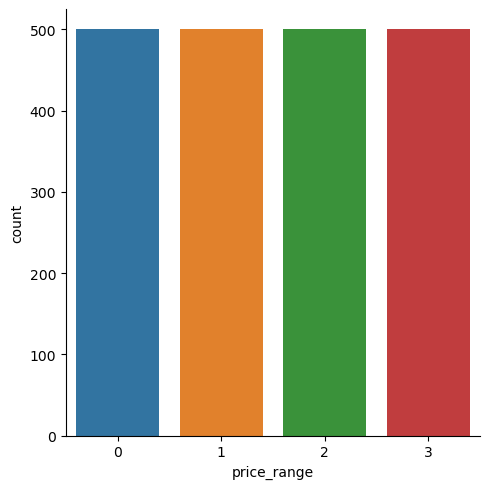

In [36]:
sns.catplot(x = 'price_range', kind = 'count', data = dataset)
plt.show()

### 2. Preprocessing (normalitzation, outlier removal, feature selection..)
Un cop vistes les dades de les que es disposa, per tal de tenir un aprenentatge més eficient, es recomana normalitzar les dades i treure outliers. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics..

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estàn les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització será més adient per les vostres dades?
* Teniu gaires dades sense informació? Els NaNs a pandas? Tingueu en compte que hi ha metodes que no els toleren durant el aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categoriques? Quina seria la codificació amb més sentit? (`OrdinalEncoder`, `OneHotEncoder`, d'altres?)
* Caldria aplicar `sklearn.decomposition.PCA`? Quins beneficis o inconvenients trobarieu?
* Es poden aplicar `PolynomialFeatures` per millorar la classificació? En quins casos té sentit fer-ho?

In [58]:
from sklearn.preprocessing import StandardScaler

def standarize(X):
    return StandardScaler().fit(X).transform(X)

X = standarize(X)

X

array([[-0.90259726, -1.40894856, -1.14678403,  0.39170341],
       [-0.49513857,  0.58577791,  1.70446468,  0.46731702],
       [-1.5376865 ,  1.39268422,  1.07496821,  0.44149774],
       ...,
       [ 1.53077336,  0.50238257,  0.88056489,  0.86013895],
       [ 0.62252745, -0.69670724, -1.34581601, -1.15745352],
       [-1.65833069, -0.3653798 , -1.15141268,  1.65500399]])

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.37774115 0.25037883]
[54.97207634 44.7552299 ]


In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[ 1.        , -0.90259726, -1.40894856, ...,  1.61575972,
        -0.55188995, -0.44919921],
       [ 1.        , -0.49513857,  0.58577791, ...,  0.99843776,
         0.27374399,  0.79652535],
       [ 1.        , -1.5376865 ,  1.39268422, ...,  1.49709126,
         0.61486693,  0.47459603],
       ...,
       [ 1.        ,  1.53077336,  0.50238257, ...,  0.44238045,
         0.43211882,  0.75740816],
       [ 1.        ,  0.62252745, -0.69670724, ...,  0.93763976,
         0.80640625,  1.55771947],
       [ 1.        , -1.65833069, -0.3653798 , ...,  0.42070293,
        -0.60470502, -1.90559259]])

### 3. Model Selection
La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de varies tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist varies tècniques, com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour, i el perceptró...
En aquesta secció heu de valorar quina o quines tècniques voleu fer servir, aixi com també explicar el per què les heu seleccionat. Recomanem, que per entendre millor la teoria, s'ha de provar com a mínim un model de SVM.

**Preguntes:**
* Quins models heu considerat?
* Considereu les SVM amb els diferents kernels implementats.
* Quin creieu que serà el més precís?
* Quin serà el més ràpid?
* Seria una bona idea fer un `ensemble`? Quins inconvenients creieu que pot haver-hi? [Documentació](https://scikit-learn.org/stable/modules/ensemble.html)

In [41]:
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.25, random_state=40)

In [42]:
def logisticRegression(x_t, x_v, y_t, y_v):
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001, max_iter=10000)

    # l'entrenem
    logireg.fit(x_t, y_t)
    print ("Classification Score Logistic : ", logireg.score(x_v, y_v))

def SVC(x_t, x_v, y_t, y_v, svc_kernel, itera=False):
    #Creem el regresor logístic
    if itera:
        svc = svm.SVC(C=1.0, kernel=svc_kernel, gamma=0.9, probability=True, max_iter=10000)
    else:
        svc = svm.SVC(C=1.0, kernel=svc_kernel, gamma=0.9, probability=True)
    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Classification Score SVM " , svc_kernel , " ", svc.score(x_v, y_v))

def knn(x_t, x_v, y_t, y_v, numbers_neighbors):
    neigh = KNeighborsClassifier(n_neighbors=numbers_neighbors)
    neigh.fit(x_t, y_t)
    prob = neigh.predict(x_v)
    print ("classification Score KNN: " , numbers_neighbors, " ", neigh.score(x_v, y_v))

def perceptron(x_t, x_v, y_t, y_v):
    clf = Perceptron(penalty='l2', max_iter=10000)
    clf.fit(x_t, y_t)
    print ("classification Score Perceptron: ", clf.score(x_v, y_v))
           
def ensembleRandomForestClassifier(x_t, x_v, y_t, y_v):
    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(x_t, y_t)
    print ("Classification Score RandomForestClassifier: ", clf.score(x_v, y_v))


In [43]:
logisticRegression(x_t, x_v, y_t, y_v)
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
SVC(x_t, x_v, y_t, y_v, 'linear', True)
SVC(x_t, x_v, y_t, y_v, 'poly', True)
SVC(x_t, x_v, y_t, y_v, 'rbf')
SVC(x_t, x_v, y_t, y_v, 'sigmoid')
for k in range(1, 10):
    knn(x_t, x_v, y_t, y_v, k)

perceptron(x_t, x_v, y_t, y_v)
ensembleRandomForestClassifier(x_t, x_v, y_t, y_v)

Classification Score Logistic :  0.942
Classification Score SVM  linear   0.9386666666666666
Classification Score SVM  poly   0.922
Classification Score SVM  rbf   0.9006666666666666
Classification Score SVM  sigmoid   0.5253333333333333
classification Score KNN:  1   0.83
classification Score KNN:  2   0.8153333333333334
classification Score KNN:  3   0.852
classification Score KNN:  4   0.84
classification Score KNN:  5   0.8486666666666667
classification Score KNN:  6   0.8486666666666667
classification Score KNN:  7   0.8466666666666667
classification Score KNN:  8   0.8466666666666667
classification Score KNN:  9   0.838
classification Score Perceptron:  0.684
Classification Score RandomForestClassifier:  0.8473333333333334


### 4. Crossvalidation
Un cop seleccionats quins models es volen testejar sobre les dades, s'han de poder evaluar correctament. Per aquests motius, haurem d'aprendre a cros-validar els resultats.
Reviseu la [documentació](https://scikit-learn.org/stable/modules/cross_validation.html) i escolliu quin tipus de crossvalidació pot ser l'adecuada pel vostre problema.

**Preguntes:**
* Per què és important cross-validar els resultats?
* Separa la base de dades en el conjunt de train-test. Com de fiables serán els resultats obtinguts? En quins casos serà més fiable, si tenim moltes dades d'entrenament o poques?
* Quin tipus de K-fold heu escollit? Quants conjunts heu seleccionat (quina k)? Com afecta els diferents valors de k?
* Es viable o convenient aplicar `LeaveOneOut`?


In [44]:
# LOGISTIC REGRESSION, SVC POLLY, KNN 9 

In [45]:
from sklearn.model_selection import KFold

def kfold(X, y):
    for i in range(2, 7):
        kf = KFold(n_splits=i)
        print("\nNumber of splits", kf.get_n_splits(X))
        for train, test in kf.split(X):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            logisticRegression(X_test, X_train, y_test, y_train)
            knn(X_test, X_train, y_test, y_train, 9)
            SVC(X_test, X_train, y_test, y_train, 'poly', True)                 

    
kfold(X, y)


Number of splits 2
Classification Score Logistic :  0.958
classification Score KNN:  9   0.89
Classification Score SVM  poly   0.952
Classification Score Logistic :  0.962
classification Score KNN:  9   0.889
Classification Score SVM  poly   0.954

Number of splits 3
Classification Score Logistic :  0.9519879969992499
classification Score KNN:  9   0.8657164291072769
Classification Score SVM  poly   0.940735183795949
Classification Score Logistic :  0.9564891222805701
classification Score KNN:  9   0.8634658664666166
Classification Score SVM  poly   0.9392348087021756
Classification Score Logistic :  0.9565217391304348
classification Score KNN:  9   0.8590704647676162
Classification Score SVM  poly   0.9370314842578711

Number of splits 4
Classification Score Logistic :  0.9473333333333334
classification Score KNN:  9   0.8506666666666667
Classification Score SVM  poly   0.928
Classification Score Logistic :  0.9553333333333334
classification Score KNN:  9   0.8493333333333334
Classif

### 5. Metric Analysis
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)).

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`.
* Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre [Pista](https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc)
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

In [46]:

def getPredictlogisticRegression(x_t, x_v, y_t, y_v, proba=False):
    
    #Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001, max_iter=10000)
    # l'entrenem
    logireg.fit(x_t, y_t)
    if proba:
        return logireg.predict_proba(x_v)
    
    return logireg.predict(x_v)
    
def getPredictSVC(x_t, x_v, y_t, y_v, svc_kernel, proba=False):
    svc = svm.SVC(C=1.0, kernel=svc_kernel, gamma=0.9, probability=True, max_iter=10000)
    svc.fit(x_t, y_t)
    if proba:
        return svc.predict_proba(x_v)
    
    return svc.predict(x_v)

def getPredictknn(x_t, x_v, y_t, y_v, numbers_neighbors, proba=False):
    neigh = KNeighborsClassifier(n_neighbors=numbers_neighbors)
    neigh.fit(x_t, y_t)
    if proba:
        return neigh.predict_proba(x_v)
    
    return neigh.predict(x_v)
        

In [47]:
y_pred_lg = getPredictlogisticRegression(x_t, x_v, y_t, y_v)
y_pred_svc_poly = getPredictSVC(x_t, x_v, y_t, y_v, 'poly')
y_pred_knn = getPredictknn(x_t, x_v, y_t, y_v, 9)

print("======= Accuracy score ==========")
print("Accuracy score of Logistic Regression: ", accuracy_score(y_v, y_pred_lg))
print("Accuracy score of SVC POLY: ", accuracy_score(y_v, y_pred_svc_poly))
print("Accuracy score of KNN 9: ", accuracy_score(y_v, y_pred_knn))

print("======= F1 score ==========")
print("F1 score of Logistic Regression: ", f1_score(y_v, y_pred_lg, average='micro'))
print("F1 score of SVC POLY: ", f1_score(y_v, y_pred_svc_poly, average='micro'))
print("F1 score of KNN 9: ", f1_score(y_v, y_pred_knn, average='micro'))

======= Accuracy score ==========
Accuracy score of Logistic Regression:  0.942
Accuracy score of SVC POLY:  0.922
Accuracy score of KNN 9:  0.838
======= F1 score ==========
F1 score of Logistic Regression:  0.942
F1 score of SVC POLY:  0.922
F1 score of KNN 9:  0.838


In [48]:
y_pred_proba_lg = getPredictlogisticRegression(x_t, x_v, y_t, y_v, True)
y_pred_proba_svc_poly = getPredictSVC(x_t, x_v, y_t, y_v, 'poly', True)
y_pred_proba_knn = getPredictknn(x_t, x_v, y_t, y_v, 9, True)

In [49]:
def average_precision_score_for_models(y_pred_prob):
    n_classes = 4
    average_precision = {}

    for i in range(n_classes):
        average_precision[i] = average_precision_score(y_v == i, y_pred_prob[:, i])
        print('Average precision score: ', average_precision[i])



In [50]:
print("======= LOGISTIC REGRESSION ==========")
average_precision_score_for_models(y_pred_proba_lg)
print("\n======= SVC Poly ==========")
average_precision_score_for_models(y_pred_proba_svc_poly)
print("\n======= KNN 9 ==========")
average_precision_score_for_models(y_pred_proba_knn)


======= LOGISTIC REGRESSION ==========
Average precision score:  0.9981907979238456
Average precision score:  0.9920031425676775
Average precision score:  0.9832888550328316
Average precision score:  0.994058572337373

======= SVC Poly ==========
Average precision score:  0.9854735238553778
Average precision score:  0.9594339499167384
Average precision score:  0.9311824817438025
Average precision score:  0.9829175084757141

======= KNN 9 ==========
Average precision score:  0.9747624199441365
Average precision score:  0.8427246053658597
Average precision score:  0.8164347536299021
Average precision score:  0.9616525505971509


In [51]:
def precisioRecallCurveAndROCCurveforModels(y_pred_prob):
    n_classes = 4
    # Compute Precision-Recall and plot curve
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_v == i, y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_v == i, y_pred_prob[:, i])

        plt.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="best")


    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_v == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Plot ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.legend()
    

======= LOGISTIC REGRESSION ==========


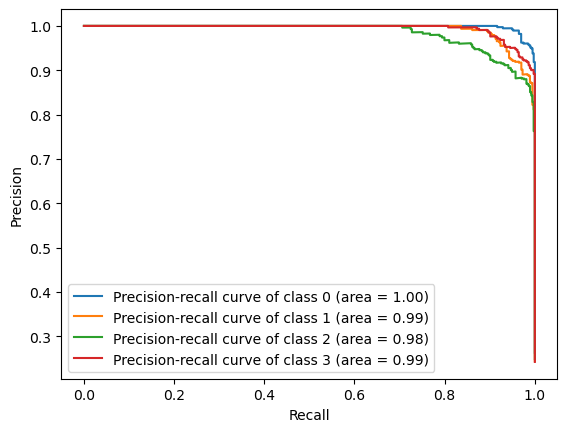

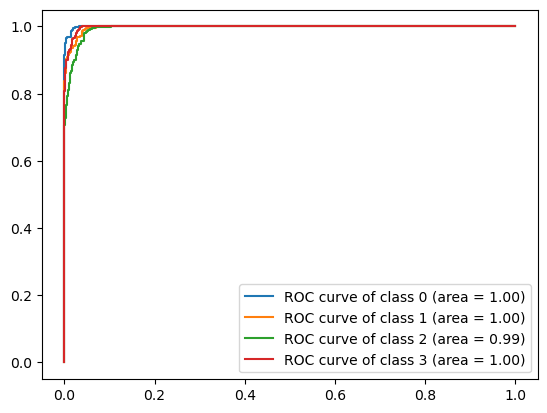

In [52]:
print("======= LOGISTIC REGRESSION ==========")
precisioRecallCurveAndROCCurveforModels(y_pred_proba_lg)


======= SVC Poly ==========


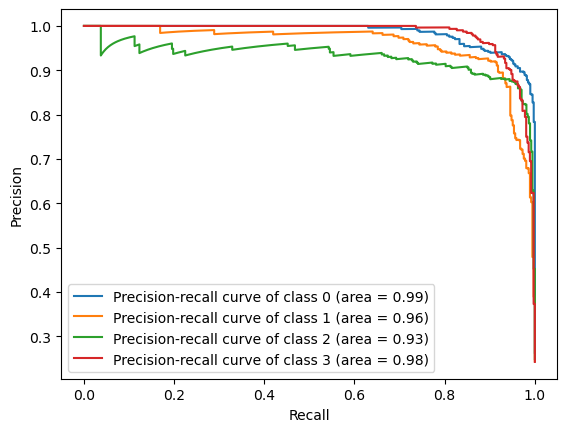

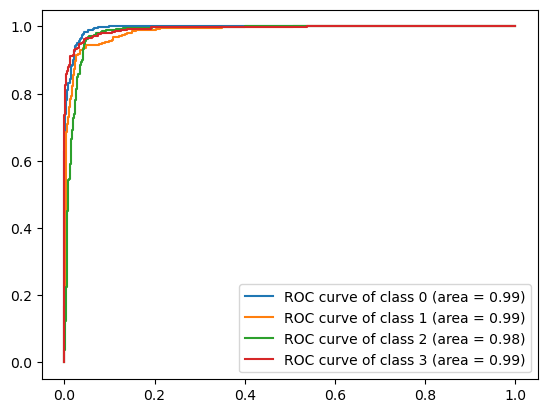

In [53]:
print("\n======= SVC Poly ==========")
precisioRecallCurveAndROCCurveforModels(y_pred_proba_svc_poly)


======= KNN 9 ==========


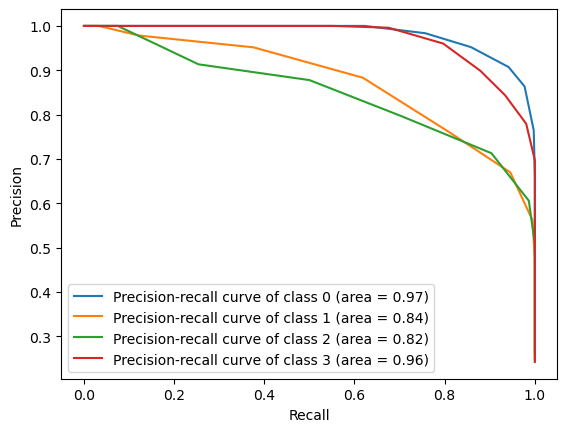

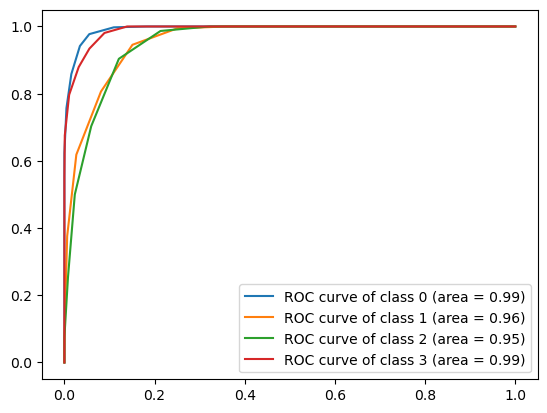

In [54]:
print("\n======= KNN 9 ==========")
precisioRecallCurveAndROCCurveforModels(y_pred_proba_knn)

In [55]:
from sklearn.metrics import classification_report
print("======= LOGISTIC REGRESSION ==========")
print(classification_report(y_v, y_pred_lg))

======= LOGISTIC REGRESSION ==========
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       395
         1.0       0.92      0.95      0.94       367
         2.0       0.92      0.91      0.91       374
         3.0       0.96      0.93      0.94       364

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



In [56]:
print("\n======= SVC Poly ==========")
print(classification_report(y_v, y_pred_svc_poly))


======= SVC Poly ==========
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       395
         1.0       0.91      0.92      0.91       367
         2.0       0.89      0.94      0.91       374
         3.0       0.96      0.89      0.92       364

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



In [57]:
print("\n======= KNN 9 ==========")
print(classification_report(y_v, y_pred_knn))


======= KNN 9 ==========
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       395
         1.0       0.74      0.86      0.79       367
         2.0       0.79      0.76      0.78       374
         3.0       0.90      0.88      0.89       364

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



### 6. Hyperparameter Search
El motiu d'aplicar crossvalidació durant l'entrenament és que ens permet conèixer quin serà el resultat esperat del nostre model un cop en producció, és a dir, com es comportarà sobre dades mai vistes abans.
A més, també ens permet optimitzar quins són els hiperparametres dels models que millor funcionaran en el futur test.

**Preguntes:**
* Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html)
* Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels dos métodes creieu que obtindrà millor resultat final?
* Existeixen altres mètodes de búsqueda més eficients ([scikit-optimize](https://scikit-optimize.github.io/stable/))?
* Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (estimeu el temps que trigarà a fer 1 training, i aixi trobeu el número de intents que podeu fer en cada cas.)

